In [1]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import MinMaxScaler


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Params
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 168
threshold = 2_000_000_000
past_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
current_date = (date.today()).strftime('%Y-%m-%d')
past_date = '2023-11-09'
current_date = '2023-11-10'
format_end = date.today().strftime('%Y%m%d')
trial = f'mrev_{format_end}'
dir_path = Path(get_strategy_mrev_etf() / 'report')
sbo = 0.85
sso = 0.85
sbc = 0.25
ssc = 0.25
etf_list = ['QQQ', 'XLE', 'XLV', 'VNQ', 'XLB', 'XLF', 'XLY', 'XLI', 'XLI', 'XLU', 'XLP']

In [3]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

# Past

In [4]:
# Find correlation between returns
def corr(df):
    # Unstack the DataFrame to get ticker returns in separate columns
    unstacked_df = df.unstack(level='ticker')
    returns_df = unstacked_df['RET_01']

    # Calculate the correlation matrix
    correlation_matrix = returns_df.corr()

    # Print pairwise correlations
    tickers = correlation_matrix.columns
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            print(f"Correlation between {tickers[i]} and {tickers[j]}: {correlation_matrix.iloc[i, j]:.4f}")

In [5]:
# Read in ETF data from FMP
T = [1]
sector_ret_past = get_data_fmp(ticker_list=etf_list, start=start, current_date=past_date)
sector_ret_past = sector_ret_past[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_past = sector_ret_past.rename(columns={'Adj Close': 'Close'})
sector_ret_past = sector_ret_past.loc[~sector_ret_past.index.duplicated(keep='first')]
# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_past = create_return(sector_ret_past, T)
corr(sector_ret_past)
sector_ret_past = sector_ret_past.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_past = sector_ret_past.unstack('ticker').swaplevel(axis=1)
sector_ret_past.columns = ['_'.join(col).strip() for col in sector_ret_past.columns.values]
sector_ret_past = sector_ret_past.fillna(0)

Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.01ticker/s]

Correlation between QQQ and VNQ: 0.6536
Correlation between QQQ and XLB: 0.7579
Correlation between QQQ and XLE: 0.5826
Correlation between QQQ and XLF: 0.6984
Correlation between QQQ and XLI: 0.7938
Correlation between QQQ and XLP: 0.6757
Correlation between QQQ and XLU: 0.5374
Correlation between QQQ and XLV: 0.7490
Correlation between QQQ and XLY: 0.8770
Correlation between VNQ and XLB: 0.6645
Correlation between VNQ and XLE: 0.5329
Correlation between VNQ and XLF: 0.7958
Correlation between VNQ and XLI: 0.7147
Correlation between VNQ and XLP: 0.6201
Correlation between VNQ and XLU: 0.6034
Correlation between VNQ and XLV: 0.5768
Correlation between VNQ and XLY: 0.7247
Correlation between XLB and XLE: 0.7571
Correlation between XLB and XLF: 0.7364
Correlation between XLB and XLI: 0.8666
Correlation between XLB and XLP: 0.6512
Correlation between XLB and XLU: 0.5791
Correlation between XLB and XLV: 0.6892
Correlation between XLB and XLY: 0.7617
Correlation between XLE and XLF: 0.6303


In [6]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
past_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_past = sector_ret_past.columns
past_data = create_return(past_data, T)
past_data = past_data.fillna(0)

In [7]:
# Execute Rolling LR
beta_data_past = rolling_ols_parallel(data=past_data, ret=ret, factor_data=sector_ret_past, factor_cols=factor_col_past.tolist(), window=window, name=f'sector_01')

In [8]:
# Retrieve Needed Data
beta_data_past = beta_data_past[beta_data_past.columns[1:14]]
beta_data_past = beta_data_past.fillna(0)

In [9]:
# Calculate rolling mean and standard deviation
rolling_mean = beta_data_past.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).mean().reset_index(level=0, drop=True)
rolling_std = beta_data_past.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).std().reset_index(level=0, drop=True)
# Calculate the rolling Z-score
beta_data_past['s_score'] = (beta_data_past[f'epsil_sector_01_{window:02}'] - rolling_mean) / rolling_std

In [10]:
# # Export data
# beta_data_past.to_parquet(get_strategy_mrev_etf_data() / 'data_beta_etf.parquet.brotli', compression='brotli')

In [11]:
tsla = get_stock_data(beta_data_past, 10104)

<AxesSubplot:xlabel='permno,date'>

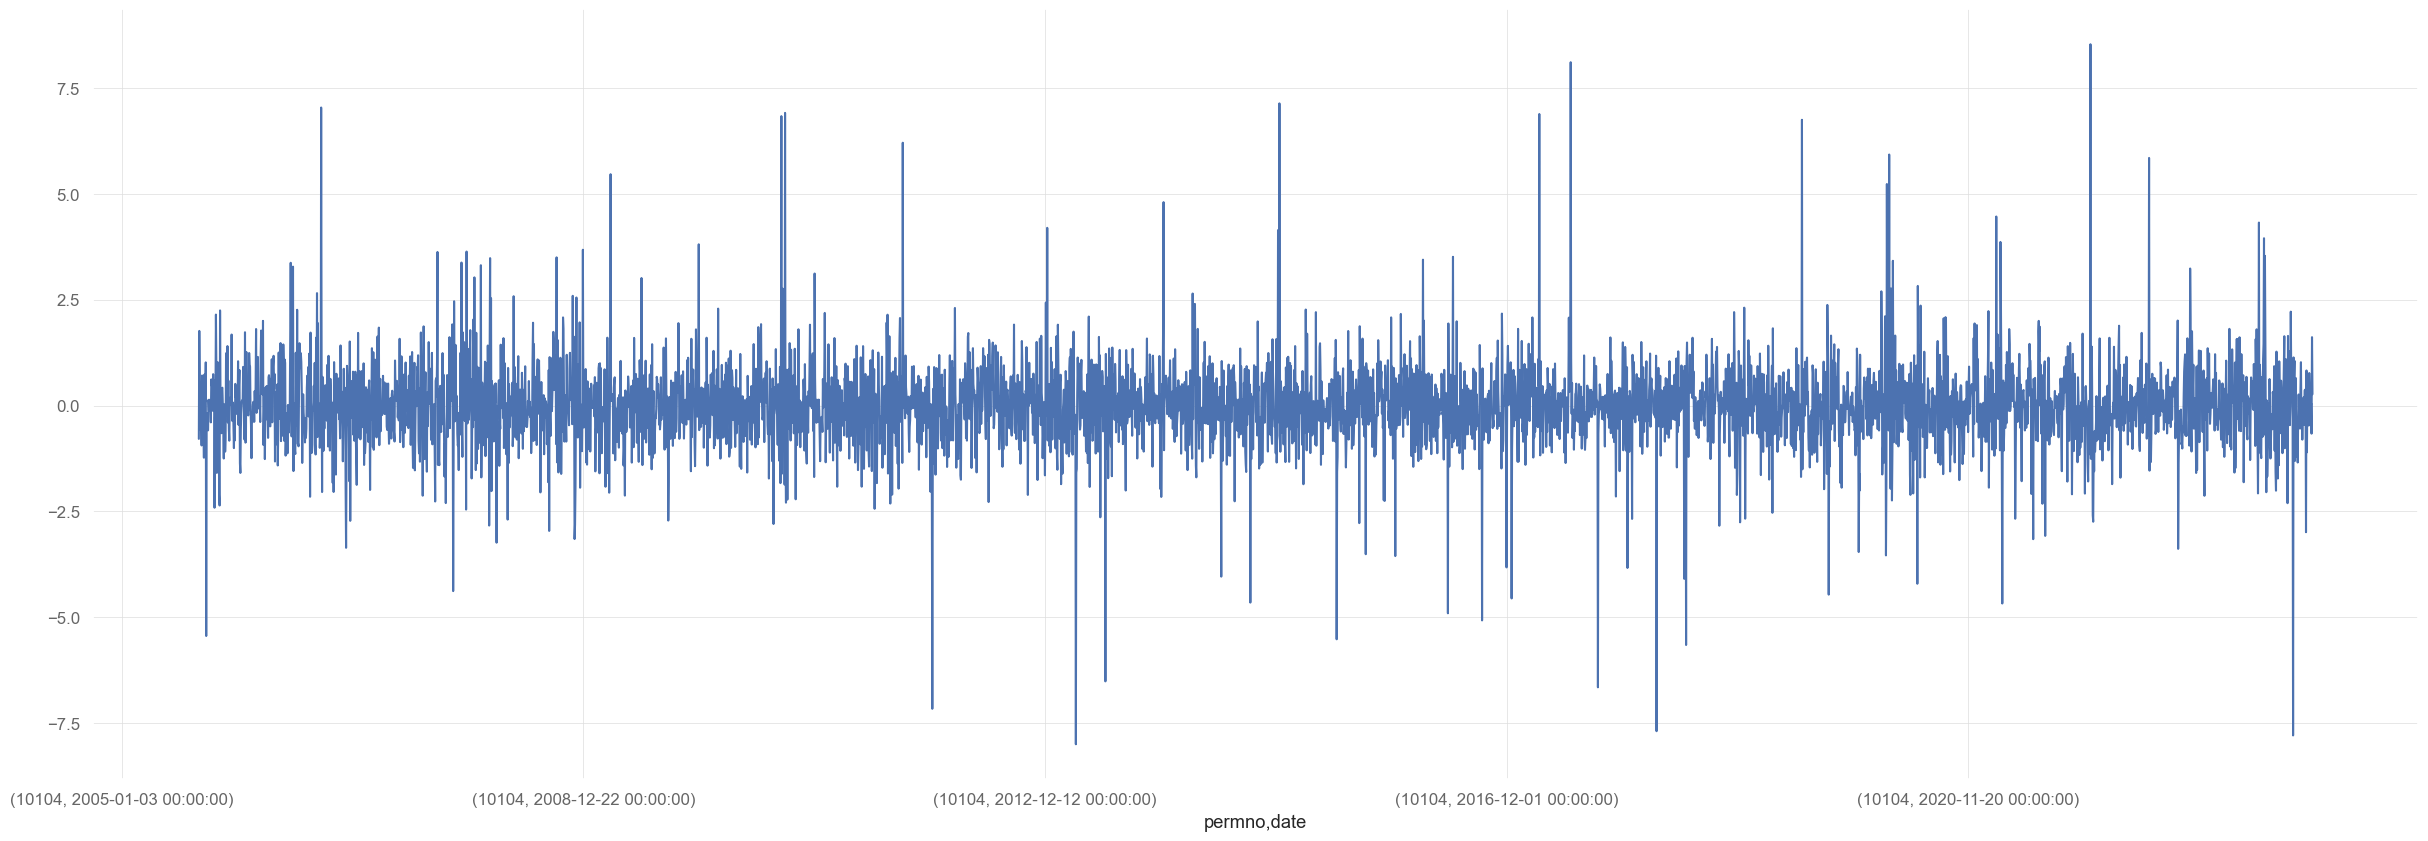

In [12]:
tsla.s_score.plot(figsize=(30, 10))

In [13]:
# Convert ETF Dataframe to multi-index
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
sector_multi_past = create_multi_index(sector_ret_past, stock)
# Merge the necessary columns together into one dataframe
combined_past = beta_data_past.merge(sector_multi_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(past_data[['RET_01']], left_index=True, right_index=True, how='left')
combined_past = combined_past.fillna(0)

In [14]:
# Retrieve the needed columns
ret_columns = [col for col in combined_past.columns if "RET_01" in col]
combined_past = combined_past[['s_score'] + ret_columns]

In [15]:
def create_signal_past(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        # Initialize signals and positions
        signals = [None] * len(group)
        positions = [None] * len(group)
        # Create masks for conditions
        open_long_condition = (group['s_score'] < -sbo) & (group['market_cap'] > threshold)
        open_short_condition = (group['s_score'] > sso) & (group['market_cap'] > threshold)
        close_long_condition = group['s_score'] > -ssc
        close_short_condition = group['s_score'] < sbc
        # Flag to check if any position is open
        position_open = False
        current_position = None
        
        for i in range(len(group)):
            if position_open:
                if positions[i-1] == 'long' and close_long_condition.iloc[i]:
                    signals[i] = 'close long'
                    positions[i] = None
                    position_open = False
                    current_position = None
                elif positions[i-1] == 'short' and close_short_condition.iloc[i]:
                    signals[i] = 'close short'
                    positions[i] = None
                    position_open = False
                    current_position = None
                else:
                    signals[i] = 'hold'
                    positions[i] = current_position
            else:
                if open_long_condition.iloc[i]:
                    positions[i] = 'long'
                    signals[i] = 'buy to open'
                    current_position = 'long'
                    position_open = True
                elif open_short_condition.iloc[i]:
                    positions[i] = 'short'
                    signals[i] = 'sell to open'
                    position_open = True
                    current_position = 'short'

        return pd.DataFrame({'signal': signals, 'position': positions}, index=group.index)

    # Sort data
    data = data.sort_index(level=['permno', 'date'])
    # Group by permno and apply the rules for each group
    results = data.groupby('permno').apply(apply_rules).reset_index(level=0, drop=True)
    # Flatten the results and assign back to the data
    data = data.join(results)
    return data

In [16]:
# Create signals
copy = combined_past.copy(deep=True)
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_past = create_signal_past(copy, sbo, sso, sbc, ssc, threshold)

In [17]:
tsla = get_stock_data(beta_data_past, 93436)

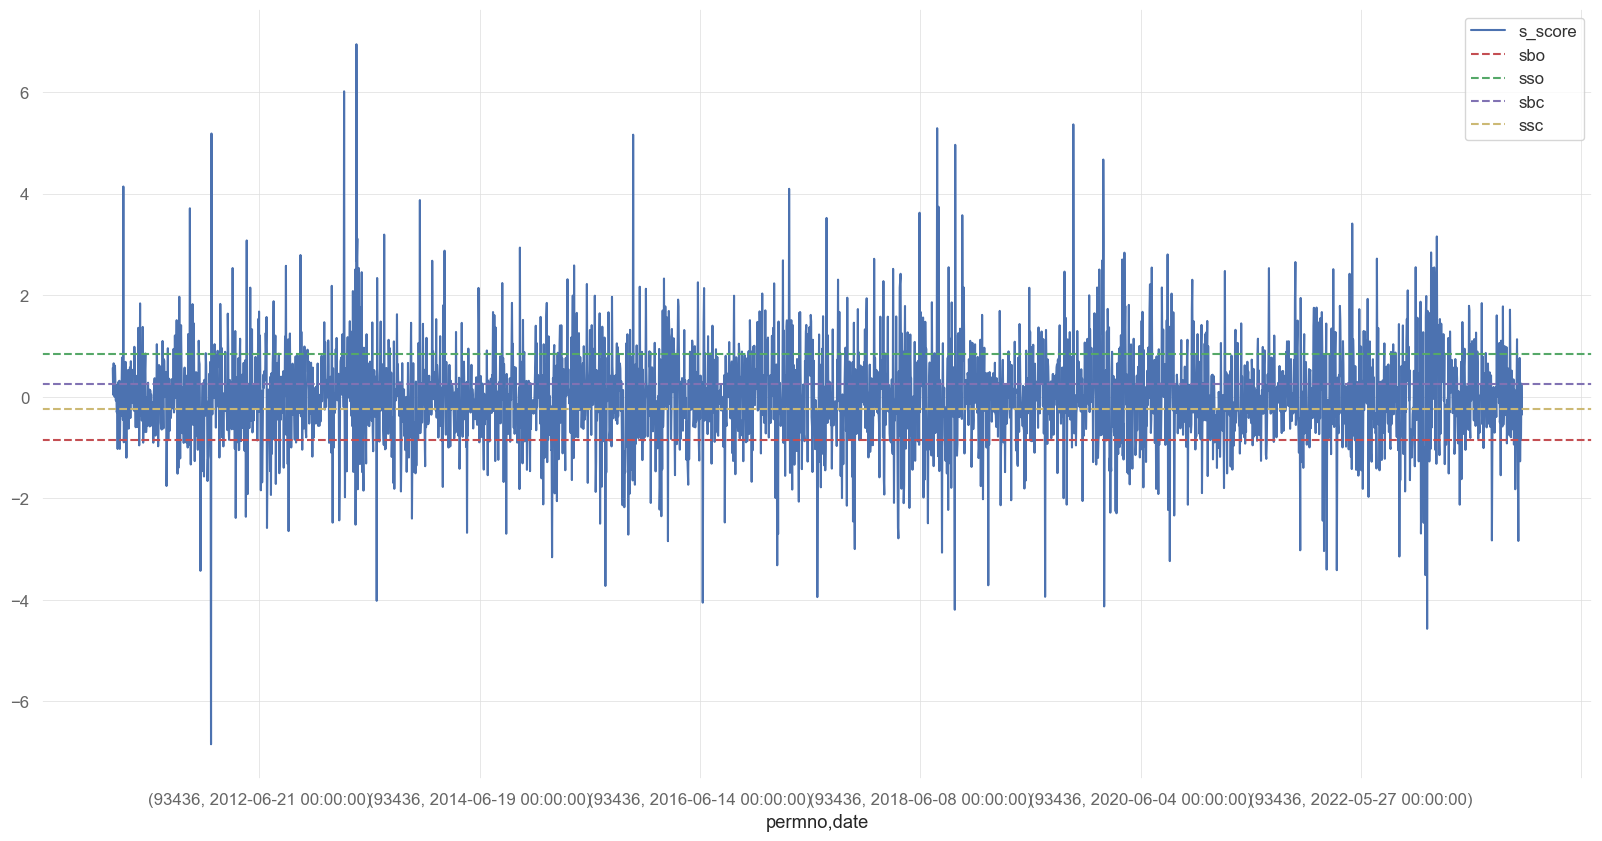

In [20]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the s_score
tsla.s_score.plot(ax=ax)
# Plot the threshold lines
ax.axhline(y=-sbo, color='r', linestyle='--', label='sbo')
ax.axhline(y=sso, color='g', linestyle='--', label='sso')
ax.axhline(y=sbc, color='m', linestyle='--', label='sbc')
ax.axhline(y=-ssc, color='y', linestyle='--', label='ssc')
# Add legend
ax.legend()
# Display the plot
plt.show()

In [21]:
def calc_total_ret(df, etf_returns):
    print("Get hedge weights...")
    mask_long = df['position'] == 'long'
    mask_short = df['position'] == 'short'
    df['hedge_weight'] = np.where(mask_long, -1, np.where(mask_short, 1, 0))
    
    # Get net hedge betas
    print("Get net hedge betas...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    weighted_betas = df[beta_columns].multiply(df['hedge_weight'], axis=0)
    net_hedge_betas = weighted_betas.groupby('date').sum()
    
    # Combine and normalize weights
    print("Normalize weights...")
    df['stock_weight'] = np.where(mask_long, 1, np.where(mask_short, -1, 0))
    
    # Normalize net hedge betas and stock weights combined
    df['abs_stock_weight'] = df['stock_weight'].abs()
    combined_weights = df.groupby('date')['abs_stock_weight'].sum() + net_hedge_betas.abs().sum(axis=1)
    df['normalized_weight'] = df['stock_weight'].div(combined_weights, axis=0)
    normalized_net_hedge_betas = net_hedge_betas.div(combined_weights, axis=0)
    
    # Get net hedge return
    print("Get net hedge returns...")
    net_hedge_returns = pd.DataFrame(index=normalized_net_hedge_betas.index)
    for beta in beta_columns:
        etf_return_column = beta.split('_sector_')[0]
        if etf_return_column in etf_returns.columns:
            net_hedge_returns[beta] = normalized_net_hedge_betas[beta] * etf_returns[etf_return_column]
    
    # Get total hedge return
    print("Get total hedge return...")
    net_hedge_return_total = net_hedge_returns.sum(axis=1)
    
    print("Get daily returns...")
    daily_returns = (df['RET_01'] * df['normalized_weight']).groupby('date').sum()
    
    print("Get total returns...")
    total_returns = daily_returns + net_hedge_return_total
    
    return total_returns, daily_returns, net_hedge_return_total, normalized_net_hedge_betas, df[['normalized_weight']]

In [22]:
result_past_copy = result_past.copy(deep=True)

In [23]:
result_past_copy['RET_01'] = result_past_copy.groupby('permno')['RET_01'].shift(-1)

In [24]:
# Calculate strategy's return
ewp_ret, daily_ret, hedge_ret, beta_weight, stock_weight = calc_total_ret(result_past_copy, sector_ret_past.shift(-1))

Get hedge weights...
Get net hedge betas...
Normalize weights...
Get net hedge returns...
Get total hedge return...
Get daily returns...
Get total returns...


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-08-31   2005-08-31
End Period                 2023-11-09   2023-11-09
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          258.4%       399.12%
CAGR﹪                     4.96%        6.29%

Sharpe                     0.46         2.71
Prob. Sharpe Ratio         97.37%       100.0%
Smart Sharpe               0.42         2.49
Sortino                    0.64         4.38
Smart Sortino              0.59         4.02
Sortino/√2                 0.45         3.09
Smart Sortino/√2           0.41         2.84
Omega                      1.63         1.63

Max Drawdown               -56.47%      -6.15%
Longest DD Days            1982         584
Volatility (ann.)          19.66%       3.28%
R^2                        0.0          0.0
Information Ratio          -0.0         -0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-08-07,2020-03-17,2020-05-19,287,-6.148286,-5.567069
2,2021-01-04,2021-11-30,2022-08-10,584,-4.044261,-3.730453
3,2009-08-20,2009-09-18,2009-10-15,57,-3.347663,-3.322465
4,2009-12-01,2010-01-20,2010-02-05,67,-2.586544,-2.572798
5,2009-05-28,2009-06-10,2009-06-25,29,-2.190476,-2.037621


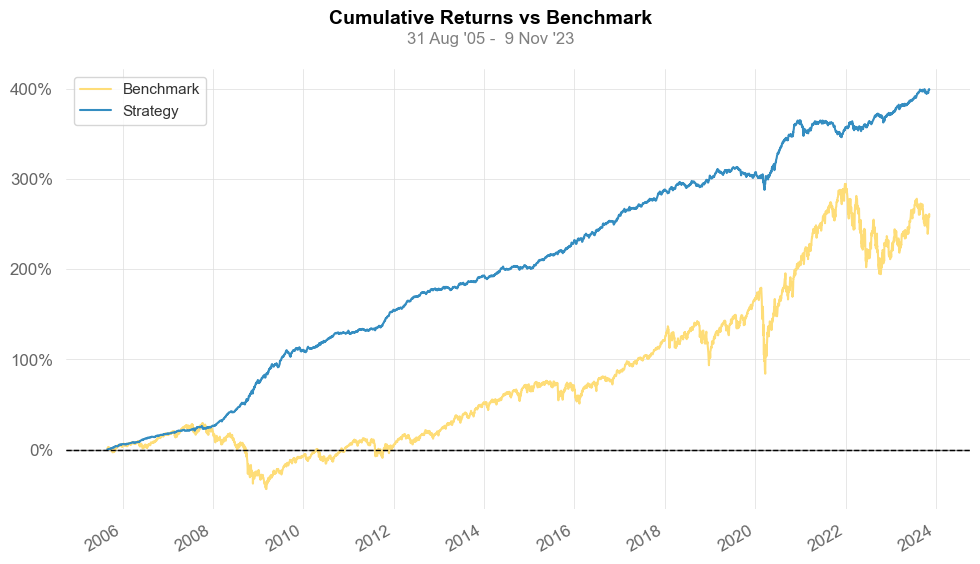

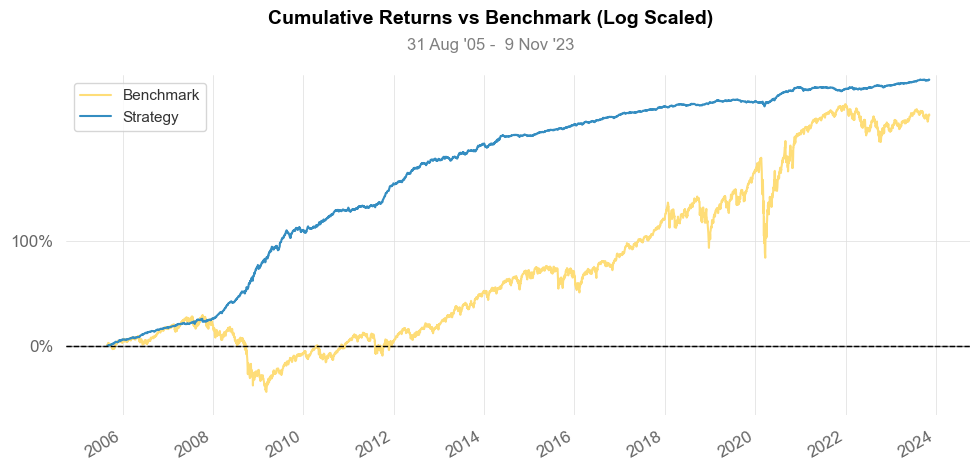

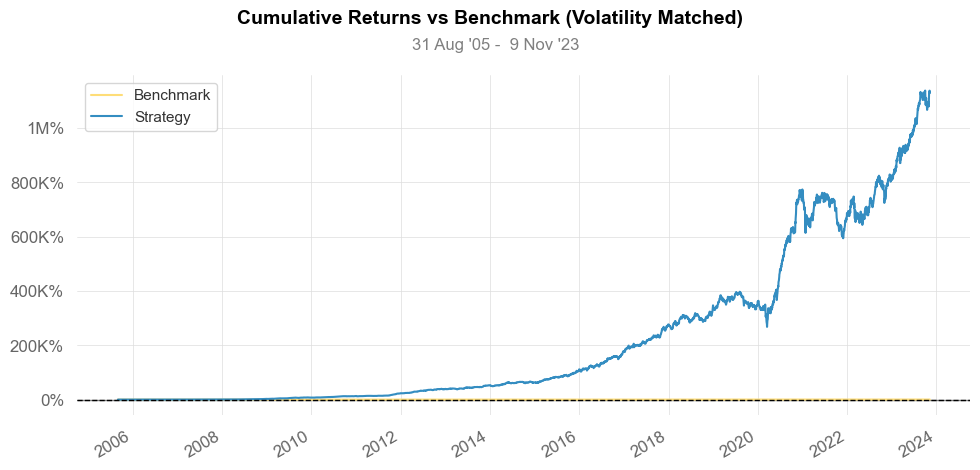

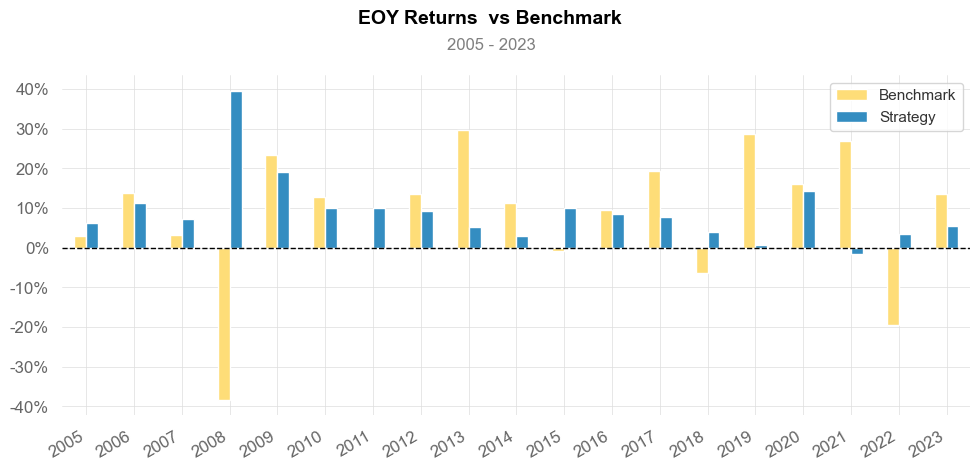

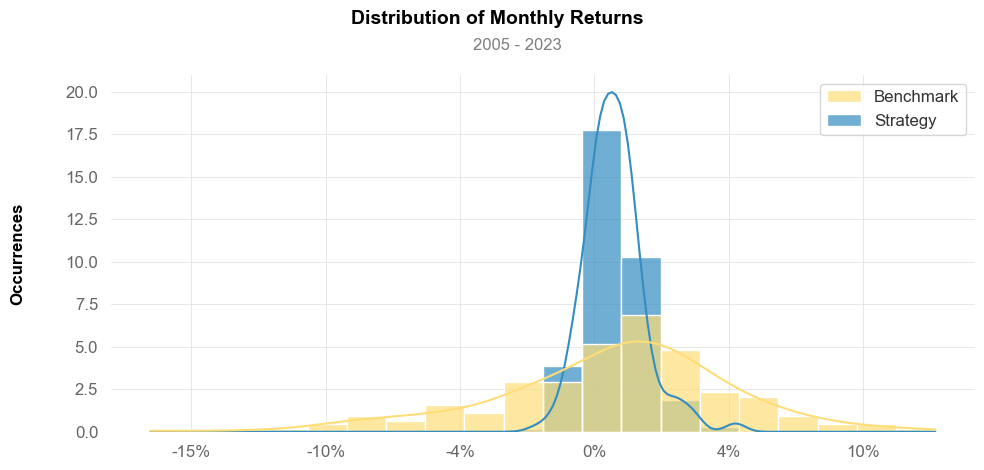

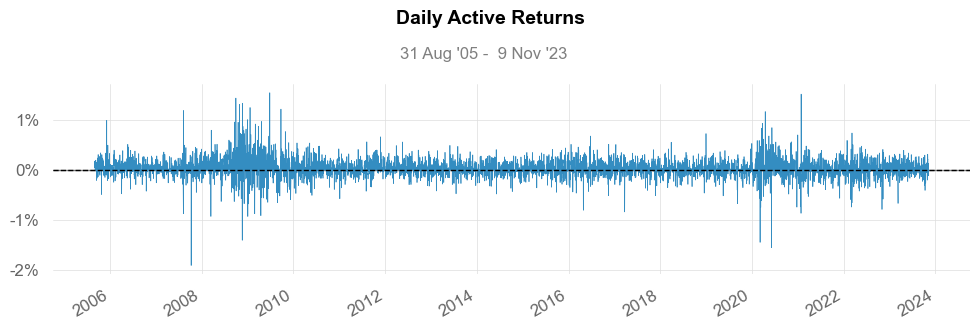

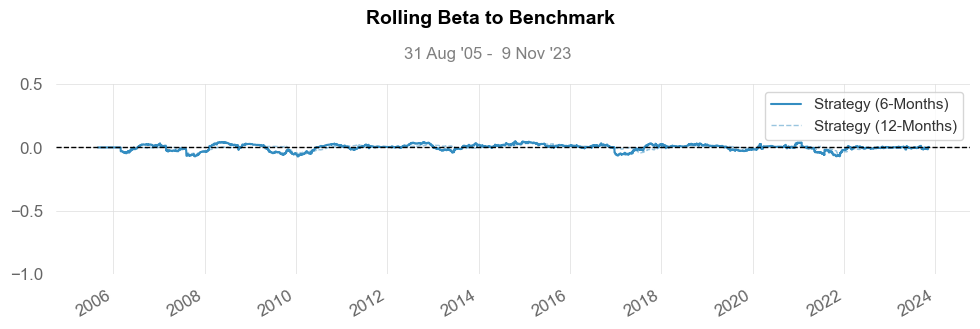

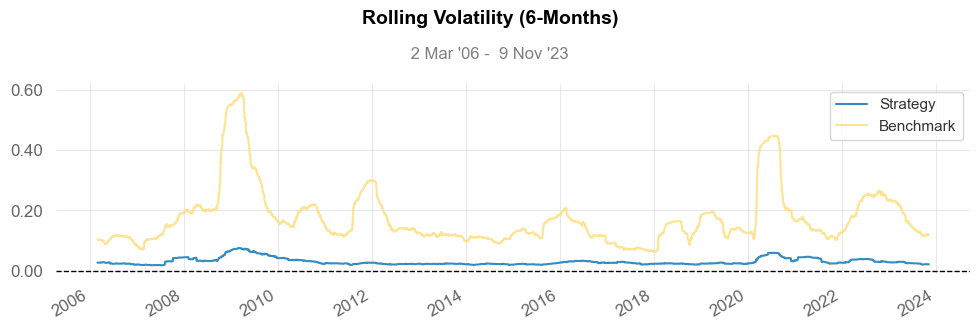

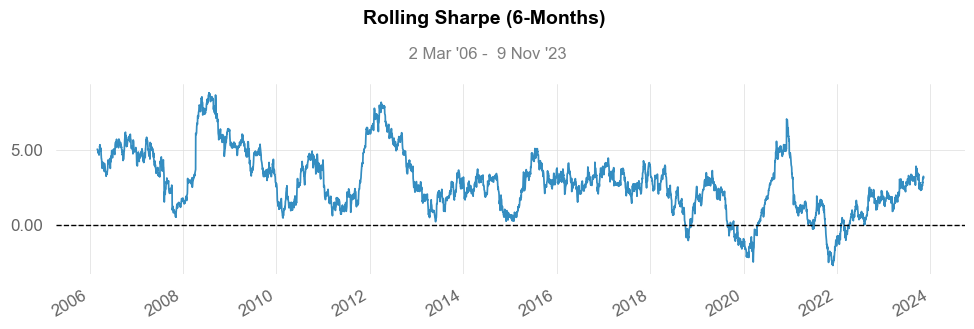

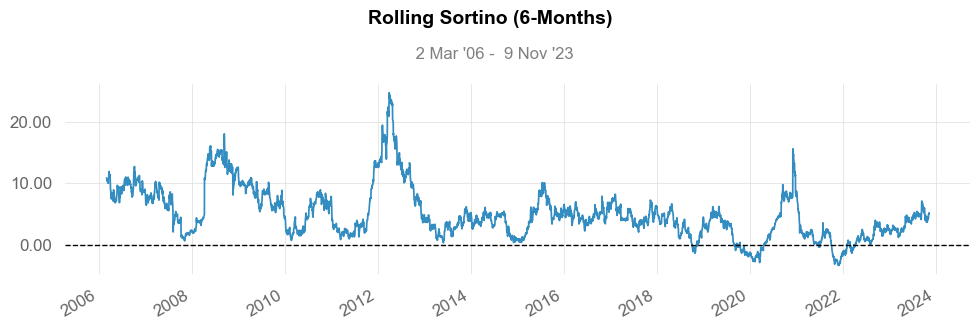

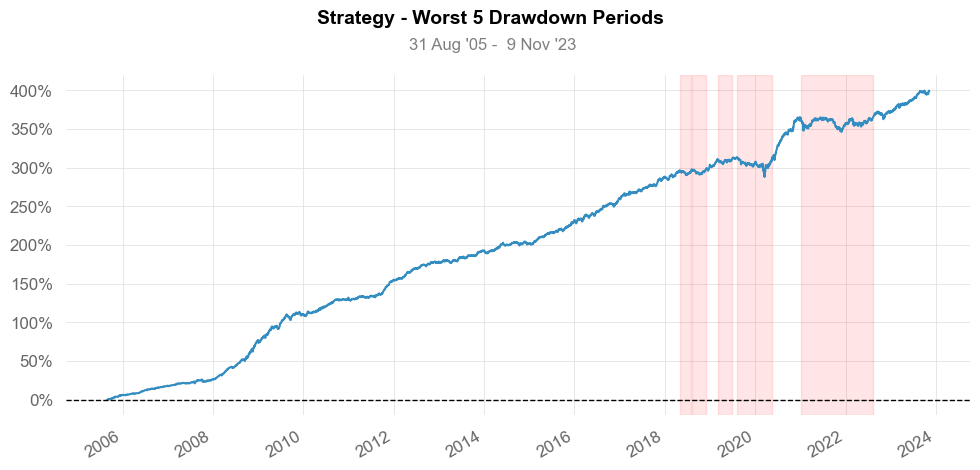

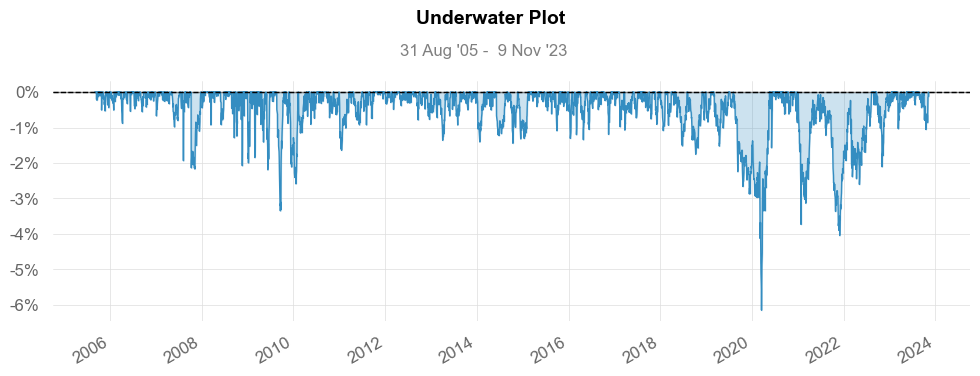

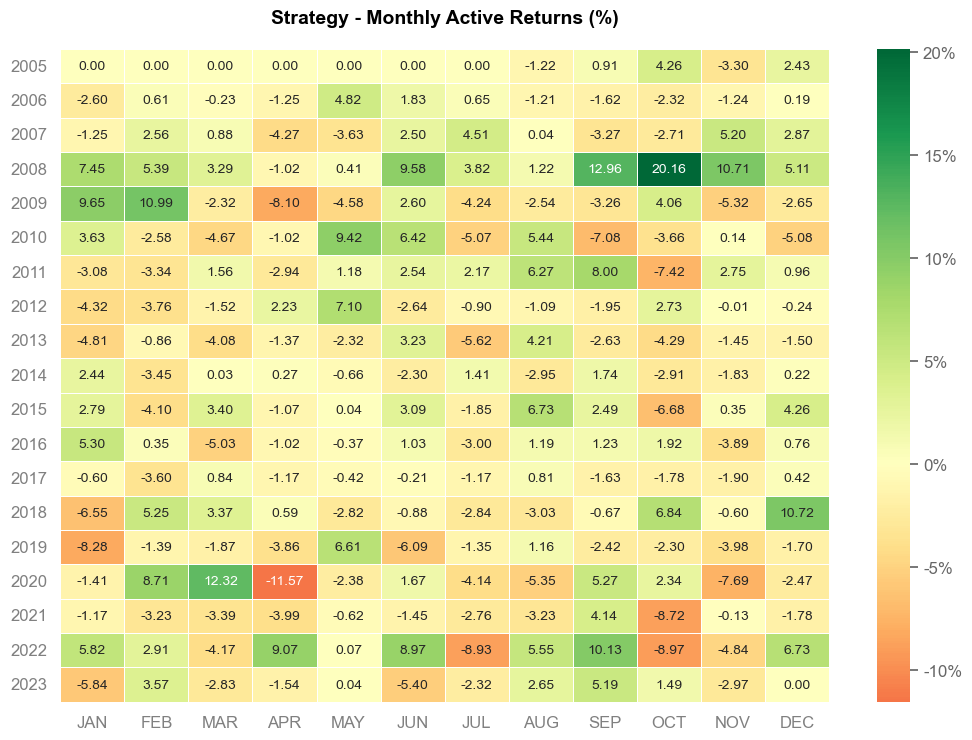

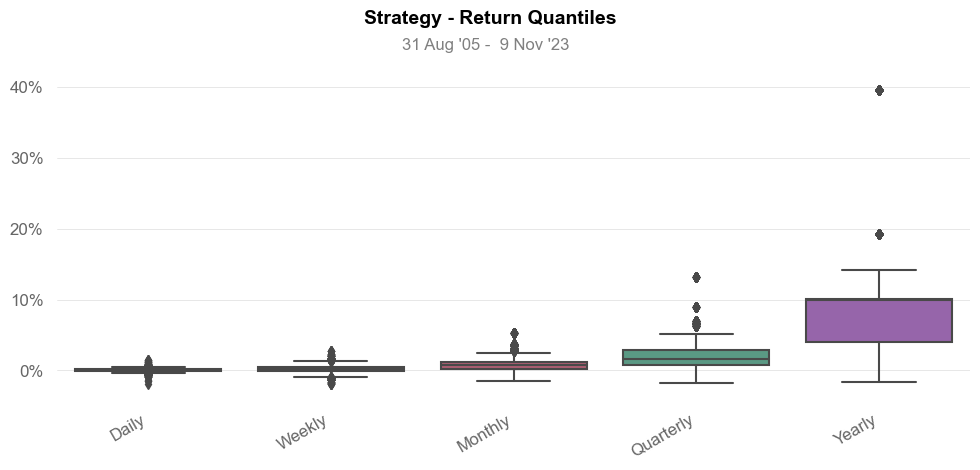

In [25]:
# Plot Results
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.full(ewp_ret, spy, figsize=(10, 5))

In [26]:
# stock_weight.to_parquet(get_strategy_mrev_etf_data() / 'data_stock_etf.parquet.brotli', compression='brotli')
# beta_weight.to_parquet(get_strategy_mrev_etf_data() / 'data_hedge_etf.parquet.brotli', compression='brotli')

In [27]:
# # Export data
# result_past_copy[['signal', 'position', 'market_cap']].to_parquet(get_strategy_mrev_etf_data() / 'data_signal_etf.parquet.brotli', compression='brotli')